In [14]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-3rd-edition/'
                 'master/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


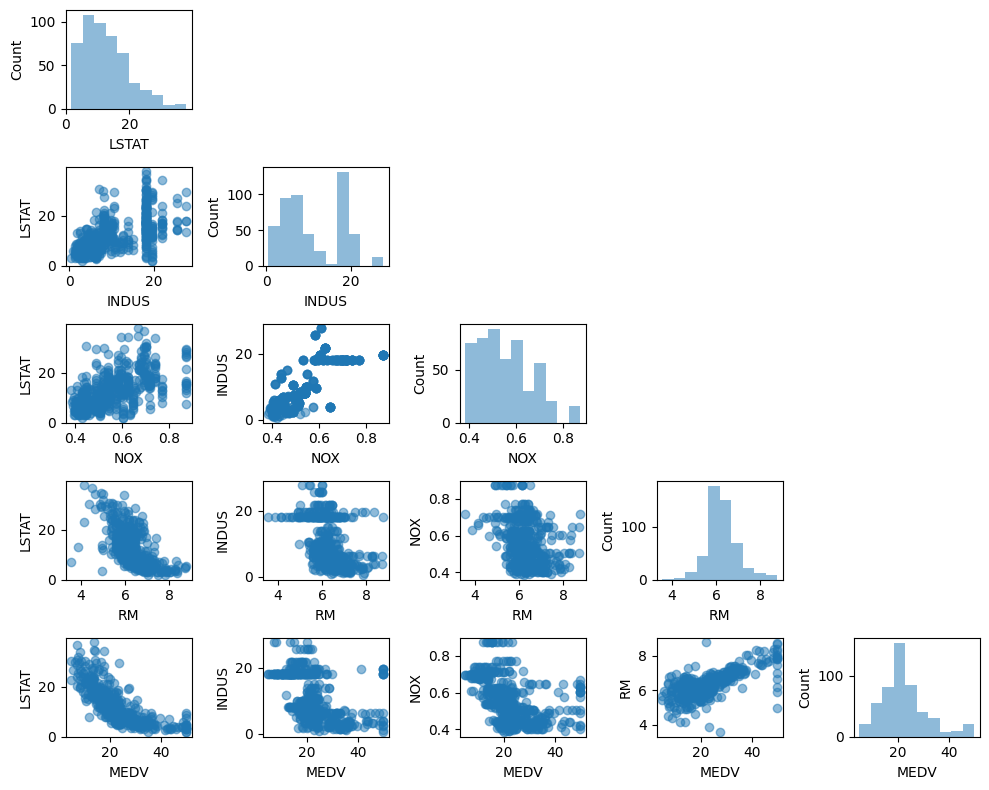

In [15]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
scatterplotmatrix(df[cols].values, figsize=(10,8), names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV'] 만 산점도 행렬에 포함 시켰다.
선형회귀가 목표이기 때문에 목표(target)인 MEDV와 선형적이 관계가 있는 데이터를 찾아야한다. (예를들어 RM)

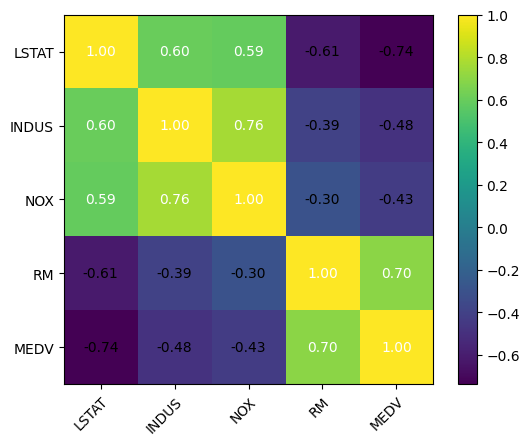

In [16]:
from mlxtend.plotting import heatmap
import numpy as np

cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm,
             row_names=cols,
             column_names=cols)
plt.show()

target인 MEDV와 상관관계가 높은 특성응을 찾아야 선형 회귀 모델의 훈련에 유리하다.
상관계수가 1이면 완벽한 양의 상관관계, -1이면 완벽한 음의 상관관계를 가지는것으로 해석된다. 즉, 절댓값이 1에 가까울수록 상관관계가 높다 볼수있다.
MEDV에 대해서는 LSTAT과 RM이 각각 높은 음의 상관관계, 양의 상관관계를 보여줬다.
하지만 RM은 MEDV와 선형적인 관계도 보였기 때문에 RM으로 특성을 선택할것이다.

In [17]:
X = df[['RM']].values
y = df['MEDV'].values

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [18]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('기울기: %.3f' %slr.coef_[0])
print('절편: %.3f' %slr.intercept_)

기울기: 9.102
절편: -34.671


In [19]:
def lin_replot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolors='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

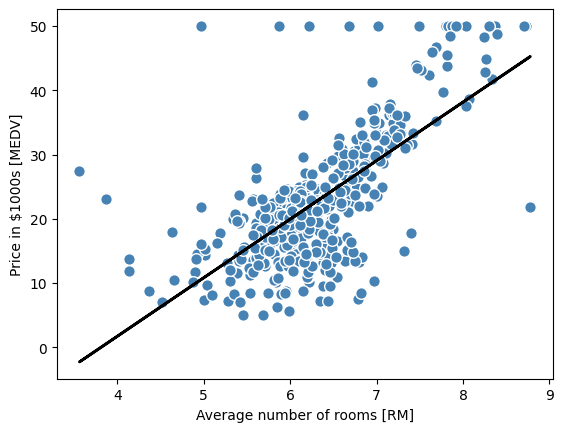

In [20]:
lin_replot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

대체적으로 방의 개수와 비례해서 집값이 늘어남을 알수있다.

선형 회귀모델은 이상치(outier)에 크게 영향을 받음으로 이를 감지하는것은 아주 중요하다,
이를 제거하는 대표 알고리즘인 RANSAC알고리즘에 대해 공부할 것이다.
이 알고리즘은 정사이(inlier)라는 일부 데이터로 회귀 모델을 훈련한다.

- RANSAC알고리즘
1. 랜덤하게 일부 샘플을 정상치로 선택하여 모델 훈련
2. 훈련된 모델에서 다른 모든 포인트를 테스트. 사용자가 입력한 허용 오차 안에 속한 포인트를 정상치에 추가
3. 모든 정상치를 사용하여 모델을 다시 훈련
4. 훈련된 모델과 정상치 간의 오차를 추정
5. 성능이 사용자 지정 임계값이나, 지정된 반복횟수로 돌아가면 알고리즘 종료. 그렇지 않을시 1번으로 복귀

In [21]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100,         # 최대 반복횟수 100
    min_samples=50,         # 랜덤하게 선택할 최소 샘플 개수 50개
    loss='absolute_error',  # 샘플 포인트 간의 수직거리의 절댓값 기준으로 loss계산
    residual_threshold=5.0, # 학습한 직선과 수직거리 5 이내에 있는 정상 샘플만 포함시킴
    random_state=0
)
ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=50, random_state=0,
                residual_threshold=5.0)

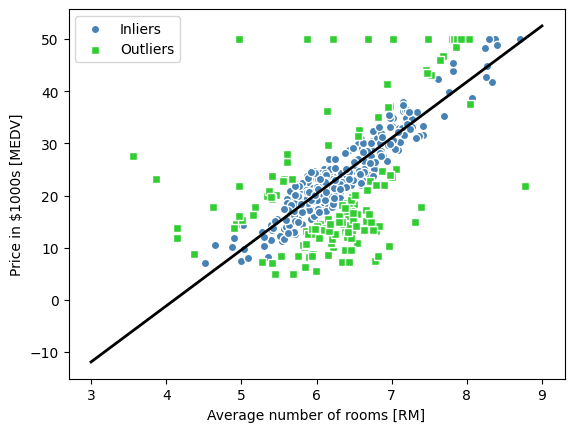

In [23]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])


plt.scatter(X[inlier_mask], y[inlier_mask], c='steelblue', edgecolors='white', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='limegreen', edgecolors='white', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()


In [24]:
print('기울기: %.3f' %ransac.estimator_.coef_[0])
print('절편: %.3f' %ransac.estimator_.intercept_)

기울기: 10.735
절편: -44.089


RANSAC을 통해 정상치를 얻고, 이를 학습해 이상치의 잠재적인 영향을 감소시킬수 있다.
하지만 처음 보는 데이터 대해 이것이 예측에서 긍정적인 영향을 끼칠 알수없다.